# New FMU interface in CasADi
Joel Andersson (joel@jaeandersson.com)

Last updated April 14, 2023

Contents:
 * Loading FMUs
 * Generating differentiable function objects from FMUs
   - First order derivatives
   - Second order derivatives
 * Simulating an FMU
 * Dynamic discretization - Implicit Runge-Kutta method
 * Solving nonlinear systems of equations
 * Forward/adjoint sentivity analysis
 * Solving nonlinear programs (NLPs) with IPOPT
 * Implementing dynamic optimization - direct collocation

## Introduction

CasADi has two existing foreign function interfaces (FFI):
 * Low level CasADi's C API -- same as the C code generated from CasADi
 * High level interface based on polymorphism:
   - Inherit from abstract base class, implement methods
   - Works from C++, Python, MATLAB/Octave
 * Neither suitable for FMI
   - CasADi functions are "pure" / state-less, FMI has state
   - Existing interfaces assume dimensions and sparsity patterns known a priori, not the case for FMI

The CasADi FMI interface represents a new way to import *differentiable* models into CasADi:
 * No external dependencies - interact directly with the FMU C API and XML API
 * Based on CasADi's existing interface to dynamically linked libraries (DLL)
   - Mature feature in CasADi - works in Windows, OSX, Linux
   - Compatible with CasADi's Clang-based just-in-time compiler
 * CasADi core feature: Use from C++, Python, MATLAB/Octave

## Modelica Example

Consider the following simple dynamic model corresponding to a controlled Van der Pol oscillator:
$$
\begin{array}{l}
\dot{x}_1 = (1-x_2^2) \, x_1 - x_2 + u \\
\dot{x}_2 = x_1 \\
\end{array}
$$
with the initial conditions for the two states given by $x_1(0) = 0$, $x_2(0) = 1$. The model has a free control $u(t) \in [-1, 1]$.

We can write this model in Modelica as follows:

In [1]:
# Toy example: Van der Pol oscillator
mofile = 'vdp.mo'
with open(mofile, 'r') as myfile: print(myfile.read())

model vdp
  Real x1(start=0, fixed = true);
  Real x2(start=1, fixed = true);
  input Real u(min = -1, max = 1);
equation
  der(x1) = (1-x2^2)*x1 - x2 + u;
  der(x2) = x1;
end vdp;



## Compiling the model into an FMU
Different tools exist to compile Modelica models like these into FMUs.

Below is a code snippet for generating FMUs using two different Modelica compilers,
the (closed-source) OCT compiler from Modelon and the open-source OpenModelica compiler:

In [2]:
#compiler = 'OCT'
compiler = 'OpenModelica'
from time import time
t1 = time()
if compiler == 'OCT':    
  # Compile using OCT, cf. OPTIMICA Compiler Toolkit (OCT) User's Guide
  from pymodelica import compile_fmu
  compiler_options = dict(generate_ode_jacobian = True)
  fmu_file = compile_fmu('vdp', [mofile], compiler_options = compiler_options)
elif compiler == 'OpenModelica':
  # Compile using OpenModelica, cf. the OpenModelica User's Guide
  from OMPython import OMCSessionZMQ
  omc = OMCSessionZMQ()
  if omc.loadFile(mofile).startswith('false'):
    raise Exception('Modelica compilation failed: {}'.format(omc.sendExpression('getErrorString()')))
  fmu_file = omc.sendExpression('translateModelFMU({})'.format('vdp'))
  flag = omc.sendExpression('getErrorString()')
  if not fmu_file.endswith('.fmu'): raise Exception('FMU generation failed: {}'.format(flag))
  print("translateModelFMU warnings:\n{}".format(flag))
else:
  raise Exception('Unknown compiler: ' + compiler)
print('Compiled %s into %s using %s in %g s' % (mofile, fmu_file, compiler, time() - t1))

translateModelFMU warnings:

Compiled vdp.mo into /home/jaeandersson/dev/casadi/docs/notebooks/vdp.fmu using OpenModelica in 1.23655 s


## Unzippling the FMU
An FMU is essentially a ZIP file containing both meta information in the form of an XML file and compiled dynamic libraries for one or more platoforms.

CasADi does *not* ship with a ZIP utility, so before the the FMU can be loaded, the user needs to unzip it.
In Python, we can easily do the unzipping with the `zipfile` package:

In [3]:
import os
import zipfile
# Unzip FMU
unzipped_name = mofile[:mofile.find('.')]
unzipped_path = os.path.join(os.getcwd(), unzipped_name)
with zipfile.ZipFile(fmu_file, 'r') as zip_ref: zip_ref.extractall(unzipped_name)
print('Unzipped %s into %s' % (fmu_file, unzipped_path))

Unzipped /home/jaeandersson/dev/casadi/docs/notebooks/vdp.fmu into /home/jaeandersson/dev/casadi/docs/notebooks/vdp


## DaeBuilder instances
The FMI interface in CasADi consists of two main components:
 - The `casadi::DaeBuilder` class which contains *mutable* interface to the model representation.
 - The `casadi::FmuFunction` class which contains an *immutable* interface to the model equations

We can create a `casadi::DaeBuilder` instance from the XML component of the FMU.

In [4]:
# Use FMU to create a CasADi/DaeBuilder instance
import casadi
t1 = time()
dae = casadi.DaeBuilder('vdp', unzipped_path)
print('Loaded %s in %g seconds' % (unzipped_path, time() - t1))
dae.disp(True)

Loaded /home/jaeandersson/dev/casadi/docs/notebooks/vdp in 0.00188804 seconds
nx = 2, nz = 0, nq = 0, ny = 0, np = 0, nc = 0, nd = 0, nw = 0, nu = 1
Variables
  x = [x1, x2]
  u = [u]
Differential equations
  \dot{x1} == der(x1)
  \dot{x2} == der(x2)


### Accessing meta information

Once loaded, we can access (or change) the meta information available in the FMU XML:

In [5]:
# Get state vector, initial conditions, bounds
x = dae.x()
lbx = dae.min(x)
ubx = dae.max(x)
x0 = dae.start(x)
print('x: ', x)
print('lbx: ', lbx)
print('ubx: ', ubx)
print('x0: ', x0)

x:  ['x1', 'x2']
lbx:  [-inf, -inf]
ubx:  [inf, inf]
x0:  [0.0, 1.0]


In [6]:
# Get free control, bounds
u = dae.u()
lbu = dae.min(u)
ubu = dae.max(u)
print('u: ', u)
print('lbu: ', lbu)
print('ubu: ', ubu)

u:  ['u']
lbu:  [-1.0]
ubu:  [1.0]


## FMU function objects

The evaluation of the FMU model equations takes place in a separate class, ``casadi::FmuFunction``, which is a standard differentiable CasADi function object. As such, it can embedded into optimization problems and have derivatives calculated automatically "under-the-hood".

FmuFunction instances are created from DaeBuilder instances, but does not depend on them after creation. Instead, they make a copy of the relevant subset of meta information in the DaeBuilder instance and stores them in the instance. If the DaeBuilder instance is later changed or deleted, it will not affect the FmuFunction. Included in the `FmuFunction` is a binary interface to the DLLs, following FMI 2.0.

In the simplest case, lets create a function object that calculate the ODE right-hand-side as a function of the state vector $x$ and the controls $u$:

In [7]:
# Evaluate ODE right-hand-side
f = dae.create('f', ['x', 'u'], ['ode'])
print(f)
# Evaluate the function numerically
u_test = 0.4
xdot_test = f(x0, u_test)
print('xdot_test: ', xdot_test)

f:(x[2],u)->(ode[2]) FmuFunction
xdot_test:  [-0.6, 0]


The creation of function objects is quite generic and it is up to the user to decide what inputs or output vectors are relevant. For example, a steady-state optimization might not have an $x$ vector at all.

Only real-valued variables that can be expected to change over subsequent function evaluations should be included in the list of inputs and outputs. For parameters that do not change during subsequent calls to the FMU -- e.g. from an optimization or simulation algorithm -- the user should set these variables in the DaeBuilder instance *before* the function creation:

In [8]:
# Alternative ODE right-hand-side function with u fixed
dae.set('u', 0.4)
f_no_u = dae.create('f_no_u', ['x'], ['ode'])
print(f_no_u)
# Evaluate the function numerically
xdot_test_no_u = f_no_u(x0)
print('xdot_test_no_u: ', xdot_test_no_u)

f_no_u:(x[2])->(ode[2]) FmuFunction
xdot_test_no_u:  [-0.6, 0]


Similarly, only real-valued, differentiable variables should be included in the list of function outputs. Other variables can be included as "auxilliary variables" by specifying the "aux" option:

In [9]:
# Evaluate ODE right-hand-side with auxilliary field
f_with_aux = dae.create('f_with_aux', ['x', 'u'], ['ode'],
               dict(aux = ['x1', 'x2', 'u']))
print(f_with_aux)
# After evaluation, the aux variables are in the stats field:
u_test = 0.4
xdot_test_with_aux = f_with_aux(x0, u_test)
print('xdot_test_with_aux: ', xdot_test_with_aux)
print(f_with_aux.stats())

f_with_aux:(x[2],u)->(ode[2]) FmuFunction
xdot_test_with_aux:  [-0.6, 0]
{'aux': {'u': 0.4, 'x1': 0.0, 'x2': 1.0}, 'u': [0.4], 'x': [0.0, 1.0]}


Anything that is not real-valued (but for example string or integer valued) can also be set this way.

### First order derivatives - Jacobians

First order derivative information can be obtained either numerically or analytically. In either case, the Jacobian sparsity information in the FMU will be exploited using CasADi's graph coloring techniques.

For efficiency, the evaluation can be done in parallel using either OpenMP or std::thread. The interface will distribute the evaluation over the available threads:

In [10]:
# A function that calculates the ODE and two Jacobian blocks:
J = dae.create('J', ['x', 'u'], ['ode', 'jac_ode_x', 'jac_ode_u'],
              dict(verbose = True, parallelization = 'openmp'))
print(J)

# Evaluate Jacobian
xdot_test, A_test, B_test = J(x0, u_test)
print('xdot_test: ', xdot_test)
print('A_test: ', A_test)
print('B_test: ', B_test)

CasADi - 2023-04-14 20:07:59 MESSAGE("J::init") [.../casadi/core/function_internal.cpp:543]
CasADi - 2023-04-14 20:07:59 MESSAGE("OpenMP using at most 24 threads") [.../casadi/core/fmu_function.cpp:1342]
CasADi - 2023-04-14 20:07:59 MESSAGE("Jacobian graph coloring: 3 -> 3 directions") [.../casadi/core/fmu_function.cpp:1472]
CasADi - 2023-04-14 20:07:59 MESSAGE("Jacobian calculation with 3 threads") [.../casadi/core/fmu_function.cpp:1549]
J:(x[2],u)->(ode[2],jac_ode_x[2x2,3nz],jac_ode_u[2x1,1nz]) FmuFunction
CasADi - 2023-04-14 20:07:59 MESSAGE("Evaluating regular outputs, forward sens, extended Jacobian") [.../casadi/core/fmu_function.cpp:1908]
xdot_test:  [-0.6, 0]
A_test:  
[[0, -1], 
 [1, 00]]
B_test:  [1, 00]


Notice that the output is sparse (00 denotes a stuctural zero).

By default, analytic derivatives will be used if they are available in the FMU. Alternatively, derivatives can be calculated using finite differences using one of three schemes:
 * Forward differences
 * Central differences
 * A smoothness seeking scheme using 5-point stencils: $f(x-2h), f(x-h), f(x), f(x+h), f(x+2h)$
 
All schemes will use perturbation sizes scaled by the nominal values in the FMU. If FMU variable bounds are present, they will be respected.

In [11]:
# A function that calculates the ODE and two Jacobian blocks:
J_fd = dae.create('J_fd', ['x', 'u'], ['ode', 'jac_ode_x', 'jac_ode_u'],
              dict(verbose = True,
                   parallelization = 'openmp',
                   enable_ad = False))
print(J_fd)

# Evaluate Jacobian
xdot_fd, A_fd, B_fd = J_fd(x0, u_test)
print('xdot_fd: ', xdot_fd)
print('A_fd: ', A_fd)
print('B_fd: ', B_fd)

CasADi - 2023-04-14 20:08:04 MESSAGE("J_fd::init") [.../casadi/core/function_internal.cpp:543]
CasADi - 2023-04-14 20:08:04 MESSAGE("OpenMP using at most 24 threads") [.../casadi/core/fmu_function.cpp:1342]
CasADi - 2023-04-14 20:08:04 MESSAGE("Jacobian graph coloring: 3 -> 3 directions") [.../casadi/core/fmu_function.cpp:1472]
CasADi - 2023-04-14 20:08:04 MESSAGE("Jacobian calculation with 3 threads") [.../casadi/core/fmu_function.cpp:1549]
J_fd:(x[2],u)->(ode[2],jac_ode_x[2x2,3nz],jac_ode_u[2x1,1nz]) FmuFunction
CasADi - 2023-04-14 20:08:04 MESSAGE("Evaluating regular outputs, forward sens, extended Jacobian") [.../casadi/core/fmu_function.cpp:1908]
xdot_fd:  [-0.6, 0]
A_fd:  
[[0, -1], 
 [1, 00]]
B_fd:  [1, 00]


Finally, the finite difference implementation can be run in "shadow mode" by setting the option "validate_ad" to True. The AD derivatives are then compared with the finite difference values and warnings are emitted if the difference exceeds a threshold. This feature is intended to help ensuring that the analytic derivatives are correct for complex physical models.

### Second order derivatives - Hessians
The interface can also calculate second derivatives, i.e. Hessians. The Hessian can be calculated for any linear combination of the outputs (in gradient-based optimization, the weights are typically Lagrange multipliers).

Using the "dependenciesKind" field in the FMI XML we can determine which input variables enter nonlinearly in any of the used outputs variables. This allows a "worst-case" sparsity pattern of the Hessian to be constructed.

The Hessian is then calculated by applying finite differencing to the first order analytic derivatives. The first order analytic derivatives are, in turn, by implicitly multiplying the Jacobian with a vector from the left, where the Jacobian is calculated using the graph coloring techniques described above. This is *not* the most efficient way to calculate second order derivatives -- a more efficient alternative is to use adjoint derivatives to calculate the first order derivatives before using either finite differences or AD for the second derivatives. Since adjoint derivatives are not available in FMI 2.0, the workaround using the calculation of the sparse Jacobian was used. If/when the FMI interface is updated to support FMI 3.0, the first order derivatives can be calculated efficiently using `fmi3GetAdjointDerivative`, if supported by the generating tool. The current gradient calculation approach can then instead be used as a diagnostics feature, checking that `fmi3GetAdjointDerivative` for correctness.

The Hessian calculation can be done in parallel, using OpenMP or std::thread. The nonlinearly entering variables are then split over the available threads:

In [12]:
# Create a function that calculate the Hessian of a linear
# combination of "ode" with respect to x and u: 
H = dae.create('H', ['x', 'u', 'adj_ode'],
               ['jac_adj_x_x', 'jac_adj_x_u', 'jac_adj_u_u'],
               dict(verbose = True, parallelization = 'openmp'))
print(H)
# Evaluate Hessian
# Evaluate Jacobian
H_xx, H_xu, H_uu = H(x0, u_test, 1)
print('H_xx: ', H_xx)
print('H_xu: ', H_xu)
print('H_uu: ', H_uu)

CasADi - 2023-04-14 20:08:11 MESSAGE("H::init") [.../casadi/core/function_internal.cpp:543]
CasADi - 2023-04-14 20:08:11 MESSAGE("OpenMP using at most 24 threads") [.../casadi/core/fmu_function.cpp:1342]
CasADi - 2023-04-14 20:08:11 MESSAGE("Jacobian graph coloring: 3 -> 3 directions") [.../casadi/core/fmu_function.cpp:1472]
CasADi - 2023-04-14 20:08:11 MESSAGE("Hessian graph coloring: 3 -> 3 directions") [.../casadi/core/fmu_function.cpp:1515]
CasADi - 2023-04-14 20:08:11 MESSAGE("Jacobian calculation with 3 threads") [.../casadi/core/fmu_function.cpp:1549]
H:(x[2],u,adj_ode[2])->(jac_adj_x_x[2x2],jac_adj_x_u[2],jac_adj_u_u) FmuFunction
CasADi - 2023-04-14 20:08:11 MESSAGE("Evaluating regular outputs, forward sens, extended Jacobian") [.../casadi/core/fmu_function.cpp:1908]
CasADi - 2023-04-14 20:08:11 MESSAGE("Evaluating extended Hessian") [.../casadi/core/fmu_function.cpp:1912]
H_xx:  
[[0, -2.00007], 
 [-2.00007, 0]]
H_xu:  [0, 0]
H_uu:  -0.000111022


In general, we have to perturb all nonlinearly entering variables, which will give us the full Hessian, not just the upper or lower triangular part. But we also know that the Hessian has to be symmetric, we can use a symmetry check as an consistency check for the Hessian calculation, without any additional calls to the FMU. In addition, the diagonal entries of the Hessian can be calculated by using second order finite differences.

Both these calculations can be done without any additional calls to the FMU, thus without significant overhead, and can thus be an important check that the entries are correctly calculated. This is especially important since the correcness of the calculation will depend on suitably chosen nominal values, for scaling the perturbation step sizes. This diagnostics feature can be enabled by setting the option "check_hessian" to True.

## Improved ODE/DAE integrator class suitable for FMI simulation
 * CasADi's ODE/DAE integrators previously only efficient for forward/adjoint sensitivity calculations
    when the ODEs/DAEs were available as *expressions*, not general *functions*
 * With CasADi 3.6, the `integrator` class also works efficiently for DAEs given as functions, including `FmuFunction` instances
 * In addition, ODE/DAE sensitivity analysis has been greatly refactored in CasADi 3.6:
    - It now supports piecewise constant controls ("u")
    - The differentiation now works when the solution is retrieved at a time grid, not just a single point
    - The integrator plugin classes much better exploit the ODE/DAE sensitivity analysis structure

In [16]:
import numpy as np
# Simulate the ODE over 10 s using CVODES
T = 10.
tgrid = np.linspace(0., T, 100)
dae.set_min(x[0], -np.inf) # relax lower bound on x1
daefun = dae.create('daefun')
sim = casadi.integrator('sim', 'cvodes', daefun, 0, tgrid)

In [17]:
# Call integrator instance
r = sim(x0 = x0, u = u_test)
x_traj_sim = r['xf'].full()

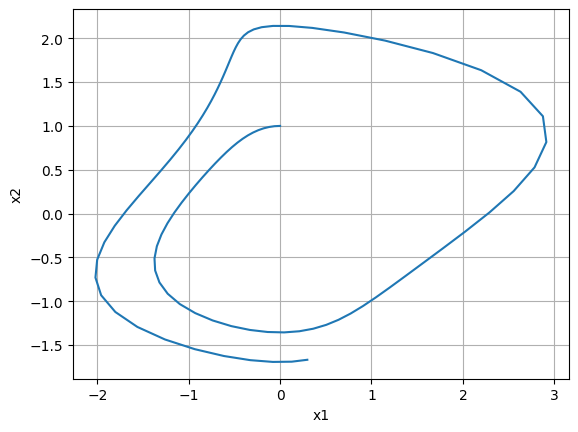

In [18]:
import matplotlib.pyplot as plt
# Plot x1 vs. x2
plt.plot(x_traj_sim[0,:], x_traj_sim[1,:])
plt.xlabel(x[0])
plt.ylabel(x[1])
plt.grid(True)

In [21]:
# Create a new integrator with support for forward sensitivities
fwd_sim = casadi.integrator('fwd_sim', 'cvodes', daefun, 0, tgrid, dict(nfwd = 1))
print(fwd_sim)
# Let's calculate sensitivity w.r.t. x1, i.e. use a forward seed [1, 0] for x0:
seed_x0 = casadi.DM([1, 0])
seed_u = casadi.DM(0)
fwd_test = fwd_sim(x0 = casadi.horzcat(x0, seed_x0), u = casadi.horzcat(u_test, u_seed))
print('fwd_x (AD, forward) = ', fwd_test['xf'][:,1])
# We can compare this result with a finite difference perturbation
pert = 1e-3
pert_sim = sim(x0=x0 + pert * seed_x0, u=u_test)
x_pert_sim = pert_sim['x'].full()
print('fwd_x (FD) = ', (x_pert_sim - x_traj_sim) / pert)

RuntimeError: .../casadi/core/function_internal.cpp:145: Error calling CvodesInterface::init for 'fwd_sim':
.../casadi/core/oracle_function.cpp:458: Assertion "it!=all_functions_.end()" failed:
No function "fwd1_daeF" in fwd_sim. Available functions: daeF,fwd1_wrap_daeF.

In [ ]:
import numpy as np
# Simulate the ODE over 10 s using CVODES
T = 10.
tgrid = np.linspace(0., T, 100)
dae.set_min(x[0], -np.inf) # relax lower bound on x1
daefun = dae.create('daefun', dict(enable_ad = None))
sim = casadi.integrator('sim', 'cvodes', daefun, 0, tgrid, dict(verbose = False, augmented_options = dict(second_order_correction = False)))

In [ ]:
# Call simulator instance
r = sim(x0 = x0, u = u_test)
x_traj_sim = r['xf'].full()

In [ ]:
import matplotlib.pyplot as plt
# Plot x1 vs. x2
plt.plot(x_traj_sim[0,:], x_traj_sim[1,:])
plt.xlabel(x[0])
plt.ylabel(x[1])
plt.grid(True)

In [ ]:
sim

In [ ]:
casadi.repmat(casadi.horzcat([u_test, 0]), 1, 100).shape

In [ ]:
# Create a new Simulator with support for forward sensitivities
fwd_sim = casadi.integrator('fwd_sim', 'cvodes', daefun, 0, tgrid, dict(nfwd = 1, verbose = False, second_order_correction = False))
print(fwd_sim)
# Let's calculate sensitivity w.r.t. x1, i.e. use a forward seed [1, 0] for x0:
seed_x0 = casadi.DM([1, 0])
fwd_test = fwd_sim(x0 = casadi.horzcat(x0, seed_x0),
                   u = casadi.horzcat(u_test, 0))
print('fwd_x (AD, forward) = ', fwd_test['xf'])
# We can compare this result with a finite difference perturbation
pert = 1e-3
pert_sim = sim(x0=x0 + pert * seed_x0, u=u_test)
x_pert_sim = pert_sim['xf'].full()
print('fwd_x (FD) = ', (x_pert_sim - x_traj_sim) / pert)

In [ ]:
x_pert_sim

In [ ]:
sim.forward(1)

In [ ]:
# Create a new Simulator with support for forward sensitivities
fwd_sim = sim.forward(1)
print(fwd_sim)
# Let's calculate sensitivity w.r.t. x1, i.e. use a forward seed [1, 0] for x0:
seed_x0 = casadi.DM([1, 0])
fwd_test = fwd_sim(x0 = x0, u = u_test, out_xf = r['xf'], fwd_x0 = seed_x0)
print('fwd_x (AD, forward) = ', fwd_test['fwd_xf'])
# We can compare this result with a finite difference perturbation
pert = 1e-3
pert_sim = sim(x0=x0 + pert * seed_x0, u=u_test)
x_pert_sim = pert_sim['xf'].full()
print('fwd_x (FD) = ', (x_pert_sim - x_traj_sim) / pert)

### Dynamic discretization - Solving nonlinear system of equations

ODEs from Modelica are typically sparse. Let us define a implicit fixed step
integrator suitable for stiff ODEs and DAEs

In [ ]:
# Number of integrator steps
N = 50
# Size of the finite elements
h = T/N

In [ ]:
# Let us use a 4th order collocation discretization using Legendre roots, cf. 
# Nonlinear Programming: Concepts, Algorithms, and Applications to Chemical Processes
# by Lorenz Biegler (2010)
d = 3
# The roots can be queried from CasADi or looked up in the above textbook
tau_root = np.append(0, casadi.collocation_points(d, 'legendre'))
# Coefficients of the collocation equation
C = np.zeros((d+1,d+1))
# Coefficients of the continuity equation
D = np.zeros(d+1)
# Coefficients of the quadrature function
B = np.zeros(d+1)
# Construct polynomial basis
for j in range(d+1):
    # Construct Lagrange polynomials
    p = np.poly1d([1])
    for r in range(d+1):
        if r != j:
            p *= np.poly1d([1, -tau_root[r]]) / (tau_root[j]-tau_root[r])
    # Evaluate at the final time to get the coefficients of the continuity equation
    D[j] = p(1.0)
    # Evaluate the time derivative to get the coefficients of the continuity equation
    pder = np.polyder(p)
    for r in range(d+1): C[j,r] = pder(tau_root[r])
    # Evaluate the integral of the polynomial to get the coefficients of the quadrature function
    pint = np.polyint(p)
    B[j] = pint(1.0)
print('tau_root: ', tau_root)
print('C: ', C)
print('D: ', D)
print('B: ', B)

In [ ]:
# Symbolic expression for the controls (piecewise constant)
U = casadi.MX.sym('U',len(u))
# Symbolic expressions for the states at each collocation point
X = [casadi.MX.sym('X_' + str(j), len(x)) for j in range(d+1)]
# Define the collocation equations
g = []
for j in range(1,d+1):
  # Expression for the state derivative at the collocation point
  xdot_j = 0
  for r in range (d+1): xdot_j += C[r,j]*X[r]
  # Append collocation equations
  g.append(h*f(X[j],U) - xdot_j)
# Concatenate constraints
g = casadi.vertcat(*g)
# Form a root-finding function, implicitly defining X[1:] as a function of U, X[0]
X_unknown = casadi.vertcat(*X[1:])
rfp = casadi.Function('rfp', [X_unknown, X[0], U], [g], ['V0', 'X0', 'U'], ['V'])

* Rootfinding instances in CasADi solves problems of the form:
 $$ g(x, p) = 0 $$
* Nonlinear system of equation can be solved with KINSOL, other Newton solvers
* Rootfinding instances are differentiable, derivatives to any order can be derived from implicit-function theorem

In [ ]:
# We can solve this system of equations using Sundials/KINSOL
ifcn = casadi.rootfinder('ifcn', 'kinsol', rfp, dict(print_level = 1))
# Take a single step of the integrator
v0 = casadi.repmat(x0, d, 1)
v0 = ifcn(v0, x0, u_test)
# State at each collocation point
x_all = casadi.reshape(v0, len(x), d)
# Prepend initial state
x_all = casadi.horzcat(x0, x_all)
# Also calculate the state at the end
xf = casadi.mtimes(x_all, D)
# Print solution
print('x_all: ', x_all)
print('xf: ', xf)

In [ ]:
# We can also use CasADi's native Newton solver
ifcn = casadi.rootfinder('ifcn', 'newton', rfp, dict(print_iteration = True))
# Take a single step of the integrator
v0 = casadi.repmat(x0, d, 1)
v0 = ifcn(v0, x0, u_test)
# State at each collocation point
x_all = casadi.reshape(v0, len(x), d)
# Prepend initial state
x_all = casadi.horzcat(x0, x_all)
# Also calculate the state at the end
xf = casadi.mtimes(x_all, D)
# Print solution
print('x_all: ', x_all)
print('xf: ', xf)

### Solvers for nonlinear systems of equations are differentiable to any order in CasADi:

In [ ]:
# We can solve this system of equations using Sundials/KINSOL
ifcn = casadi.rootfinder('ifcn', 'kinsol', rfp, dict(print_level = 1))
# Differentiate Newton solver
jac_ifcn = ifcn.jacobian()
sol = jac_ifcn(V0 = v0, X0 = x0, U = u_test)
# Jacobian of state at collocation points w.r.t. U
print('jac_V_U = ', sol['jac_V_U'])
# Jacobian of state at collocation points w.r.t. X0
print('jac_V_X0 = ', sol['jac_V_X0'])

In [ ]:
# Compare with finite differences
pert = 1e-3
# Perturn u
v0_pert = ifcn(casadi.repmat(x0, d, 1), x0, u_test + pert)
jac_V_U_fd = (v0_pert - v0) / pert
print('jac_V_U (FD) = ', jac_V_U_fd)
# Perturb x1
v0_pert = ifcn(casadi.repmat(x0, d, 1), x0 + casadi.DM([pert, 0]), u_test)
jac_V_X0_fd1 = (v0_pert - v0) / pert
# Perturb x2
v0_pert = ifcn(casadi.repmat(x0, d, 1), x0 + casadi.DM([0, pert]), u_test)
jac_V_X0_fd2 = (v0_pert - v0) / pert
print('jac_V_X0 (FD) = ', casadi.horzcat(jac_V_X0_fd1, jac_V_X0_fd2))

In [ ]:
x0

In [ ]:
# Let's create a CasADi function for simulating the whole trajectory using Kinsol
ifcn = casadi.rootfinder('ifcn', 'kinsol', rfp)
x0_in = casadi.MX.sym('x0', len(x))
u_all = []
xk = x0_in
x_all = [x0_in]
for k in range(N):
    # Symbolic expression for the control for the interval
    uk = casadi.MX.sym('u' + str(k), len(u))
    u_all.append(uk)
    # Solve rootfinding problem, using previous step as guess
    vk = ifcn(casadi.repmat(xk,d,1), xk, uk)
    # Reshape and prepend initial state
    vk = casadi.reshape(vk, len(x), d)
    vk = casadi.horzcat(xk, vk)
    # Get the state at the end
    xk = casadi.mtimes(vk, D)
    # Save trajectory
    x_all.append(xk)
# Embed in a CasADi Function
irksim = casadi.Function('irksim', [x0_in, casadi.vcat(u_all)], [casadi.hcat(x_all)],
                         ['x0', 'u'], ['x'])
# Evaluate the function
x_traj = irksim(x0, u_test).full()

In [ ]:
# Plot x1 vs. x2
plt.clf()
plt.plot(x_traj_sim[0,:], x_traj_sim[1,:], 'o', label = 'CVodes')
plt.plot(x_traj[0,:], x_traj[1,:], '-', label = 'Implicit Runge-Kutta with Kinsol')
plt.xlabel(x[0])
plt.ylabel(x[1])
plt.grid(True)
plt.legend()

## ODE/DAE sensitivity analysis

In [ ]:
# A nonlinear equation solver is a differentiable object in CasADi.
# We can differentiate it analytically to get the Jacobian-times-vector product:
fwd_irksim = irksim.forward(1)
# Let's calculate sensitivity w.r.t. x1, i.e. use a forward seed [1, 0] for x0:
seed_x0 = casadi.DM([1, 0])
fwd_test = fwd_irksim(x0 = x0, u = u_test, fwd_x0 = seed_x0)
print('fwd_x (AD, forward) = ', fwd_test['fwd_x'])
# We can compare this result with a finite difference perturbation
pert = 1e-3
x_pert = irksim(x0 + pert * seed_x0, u_test).full()
print('fwd_x (FD) = ', (x_pert - x_traj) / pert)

In [ ]:
# Now let's to a reverse mode AD, i.e. a transposed-Jacobian-times-vector product
adj_irksim = irksim.reverse(1)
# We seed the last entry in x2
seed_x = casadi.DM.zeros(2, N + 1)
seed_x[1, N] = 1
adj_test = adj_irksim(x0 = x0, u = u_test, adj_x = seed_x)
print('adj_x0 (AD, reverse) = ', adj_test['adj_x0'])
print('adj_u (AD, reverse) = ', adj_test['adj_u'])

In [ ]:
# We can check that the result is consistent with forward mode AD:
print('Forward mode: derivative of x[1, N] w.r.t. x0[0] = ', fwd_test['fwd_x'][1, N])
print('Reverse mode: derivative of x[1, N] w.r.t. x0[0] = ', adj_test['adj_x0'][0])

In [ ]:
# We can also calculate the full Jacobian of x w.r.t. x0 and u:
jac_irksim = irksim.jacobian()
jac_test = jac_irksim(x0 = x0, u = u_test)
print('jac_x_x0 = ', jac_test['jac_x_x0'])
print('jac_x_u = ', jac_test['jac_x_u'])

In [ ]:
# Note the sparsity pattern of dx/du:
plt.spy(jac_test['jac_x_u'].sparse())
plt.show()

## Dynamic optimization
Now let us find the control signals that minimize the cost function
$$ J := \sum_{k = 0}^{N}{\|u_k\|^2 + \|x_{k+1}\|^2} $$
We will embed the implicit Runge-Kutta discretization in a nonlinear program (NLP), which results in a simultaneous method for dynamic optimization. For details, cf. e.g. Biegler (2010)

In [ ]:
# We will construct an NLP incrementally, starting with no decision variables, 
# and constraints, and zero objective
w = []
g = []
J = 0
# Loop over all control intervals, constructing the NLP and x, u trajectories
U_all = []
X_all = []
xk = casadi.MX(x0)
for k in range(N):
    # Symbolic expression for the control for the interval
    uk = casadi.MX.sym('u' + str(k), len(u))
    U_all.append(uk)
    w.append(uk)
    # States at each collocation point for the interval
    Xc = [xk]
    for j in range(1, d + 1):
        xkj = casadi.MX.sym('x' + str(k) + '_' + str(j), len(x))
        Xc.append(xkj)
        X_all.append(xkj)
        w.append(xkj)
    # Collect the collocation equations
    for j in range(1,d+1):
      # Expression for the state derivative at the collocation point
      xdot_j = 0
      for r in range (d+1): xdot_j += C[r,j]*Xc[r]
      # Append collocation equations
      g.append(h*f(Xc[j],uk) - xdot_j)
    # State at the end of the interval
    xk_end = 0
    for j in range(0,d+1): xk_end = xk_end + D[j] * Xc[j]
    # New variable for the state at the end of the interval
    xk = casadi.MX.sym('x' + str(k + 1), len(x))
    X_all.append(xk)
    w.append(xk)
    # Enforce continuity
    g.append(xk_end - xk)
    # Add contributions to the objective
    J = J + casadi.sumsqr(uk) + casadi.sumsqr(xk)
# Concatenate vectors
w = casadi.vcat(w)
g = casadi.vcat(g)
X_all = casadi.hcat(X_all)
U_all = casadi.hcat(U_all)
# Create mappings from (u, x) -> (w) and back
to_w = casadi.Function('to_w', [X_all, U_all], [w], ['x', 'u'], ['w'])
from_w = casadi.Function('from_w', [w], [X_all, U_all], ['w'], ['x', 'u'])
# Form the NLP
nlp = dict(x = w, f = J, g = g)

In [ ]:
# Let's form the Jacobian of g w.r.t. w
t0 = time()
jac_g_w = casadi.jacobian(g, w)
print('Symbolic expression for Jacobian of g w.r.t w formed in %g s' % (time() - t0))
# Create a function for evaluation
t0 = time()
jfcn = casadi.Function('jfcn', [w], [jac_g_w], ['w'], ['jac_g_w'])
print('Jacobian function formed in %g s' % (time() - t0))
# Evaluate function
w_test = to_w(u = u_test, x = x0)['w']
t0 = time()
J_test = jfcn(w_test)
print('Jacobian evaluated in %g s' % (time() - t0))
# Let's look at the sparsity pattern
plt.spy(J_test.sparse())
plt.show()

Formulate as a noninear program. In CasADi, they take the form:
 $$ \begin{array}{cl}
 \text{minimize} &  f(x, p) \\
    \text{subject to} & \underline{x} \le x \le \overline{x} \\
     & \underline{g} \le g(x, p) \le \overline{g} \\
     & p = \underline{\overline{p}}
    \end{array}
     $$
     
CasADi will generate efficient derivative information and pass it to the specific solver

Multiple solver plugins, including IPOPT:

In [ ]:
# Create an IPOPT instance, using L-BFGS
opts = dict(ipopt = dict(hessian_approximation = 'exact', linear_solver = 'mumps'))
solver = casadi.nlpsol('solver', 'ipopt', nlp, opts)

In [ ]:
# Generate initial guess for w
w0 = to_w(u = 0, x = x0)['w']
# Lower bound for w
lbw = to_w(u = lbu, x = lbx)['w']
# Upper bound for w
ubw = to_w(u = ubu, x = ubx)['w']
# Solve NLP
sol = solver(x0 = w0, lbx = lbw, ubx = ubw, lbg = 0, ubg = 0)

In [ ]:
sol

In [ ]:
# Extract solution
w_sorted = from_w(w = sol['x'])
x_opt = w_sorted['x']
u_opt = w_sorted['u']
# Add x0 to the beginning of x
x_opt = casadi.horzcat(x0, x_opt)
# Only keep the points at the interval boundaries
x_opt = x_opt[:, 0::d+1]
# Convert to numpy arrays
x_opt = x_opt.full()
u_opt = u_opt.full()
# Plot solution
plt.figure()
plt.plot(x_opt[0,:], x_opt[1,:])
plt.xlabel(x[0])
plt.ylabel(x[1])
plt.title("Optimal state trajectory")
plt.grid(True)
# Also plot as a function of time
grid = np.linspace(0, T, N+1)
# Plot the results
plt.figure()
plt.clf()
plt.plot(grid, x_opt[0,:],'--', label = x[0])
plt.plot(grid, x_opt[1,:],'-.', label = x[1])
plt.step(grid, np.concatenate(([np.nan], u_opt[0,:])),'-', label = u[0])
plt.title("Optimal solution")
plt.xlabel('time')
plt.legend()
plt.grid()

## Summary
 * New general-purpose FMI interface to CasADi
   - Mutable interface to XML: DaeBuilder
   - Function interface to DLL: FmuFunction
 * Jacobian calculation:
   - Sparsity exploitation
   - Parallelized
   - AD or FD
   - Higher order FD schemes
   - FD respects variable bounds
   - User can control step sizes by modifying nominal values
   - Diagnostics, e.g. using FD to validate AD
 * Hessian calculation:
   - AD for first order, FD for second order
   - Sparsity information using "DependenciesKind" in FMU
   - Parallelized
   - Diagnostics, e.g. symmetry check
 * New ODE simulation class in CasADi
 * Proof-of-concept adjoint sensitivity analysis
 * Proof-of-concept dynamic optimization with second derivatives

## Outlook
 * Use for challenging problems
 * Break up complex system models into aggregated component models
   - Faster compilation
   - Easier reuse
   - Faster derivative calculations
 * Handle hybrid dynamics
   - Idea: Make it easy to reformulate as multi-stage problem

## Possible extensions
 * Analytic second derivatives using source code FMU
 * Code generation
   - Embed FMU calls into self-contained generated C code. Link statically with FMU.
 * Symbolic model import, revisited
   - Update OCT-CasADi workflow
 * Model-predictive control
   - Interface with ACADOS (https://github.com/acados/acados) for NMPC, NMHE, etc?